In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import shap

## Data Information
+ application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
+ bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
+ bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
+ previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
+ POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
+ credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
+ installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

![img](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

print(app_train.shape)
print(app_test.shape)

(307511, 122)
(48744, 121)


## Feature Engineering

In [3]:
app_train['DAYS_BIRTH'] = -1 * app_train['DAYS_BIRTH']
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/365
app_train['DAYS_EMPLOYED'].replace({365243, np.nan}, inplace = True)
app_train['DAYS_ID_PUBLISH'] = -1*app_train['DAYS_ID_PUBLISH']

In [4]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**bureau** 데이터의 SK_ID_CURR 하나당 SK_ID_BUREAU가 여러개 있으므로 통합한다. 

In [5]:
previous_loan_counts = bureau.groupby(['SK_ID_CURR'], as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# missing value: 44020 
train['previous_loan_counts'].isna().sum()

44020

previus_loan_counts 에서 missing value는 곧 previous loan이 없다는 뜻이므로 0으로 대체한다.

In [7]:
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)

In [8]:
bureau_agg = bureau.drop(columns = 
                         ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [9]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))
            
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [10]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Deal with Categorical variables
범주형 변수(categorical variable)의 범주의 수를 시각화한 결과는 아래와 같다. 
 + 범주가 2개인 변수: One-hot encoding
 + 범주가 10개 이하인 변수: Label Encoding
 + 범주가 10개 이상인 변수: Target Encoding with smoothing

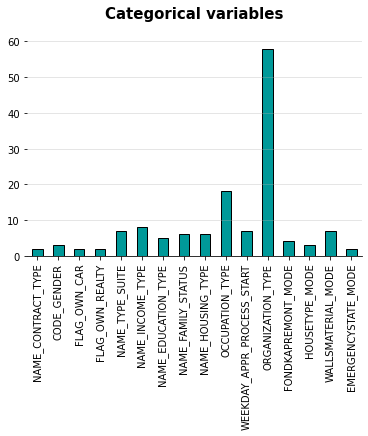

In [11]:
ax = train.select_dtypes('object').nunique().plot.bar(color = '#009999', edgecolor = 'k')

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Categorical variables', fontweight= 'bold', fontsize = 15, pad = 20)
plt.show()

In [12]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### 특이사항
train의 CODE_GENDER에 XNA라는 범주가 있음 --> 해당 데이터 제거

In [13]:
train = train[train['CODE_GENDER'] != 'XNA']

#### Test set

In [14]:
app_test['DAYS_BIRTH'] = -1 * app_test['DAYS_BIRTH']
app_test['YEARS_BIRTH'] = app_test['DAYS_BIRTH']/365
app_test['DAYS_EMPLOYED'].replace({365243, np.nan}, inplace = True)
app_test['DAYS_ID_PUBLISH'] = -1*app_test['DAYS_ID_PUBLISH']

In [15]:
test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

Test set의 각 범주형 변수의 unique한 범주의 수가 Train set과 같은지 확인

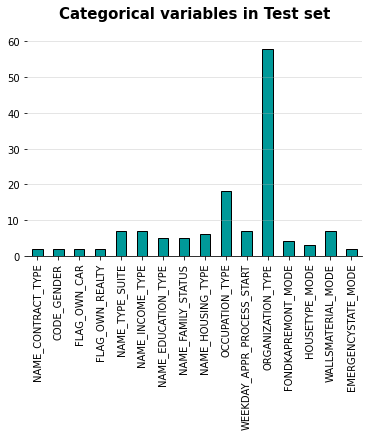

In [16]:
ax = test.select_dtypes('object').nunique().plot.bar(color = '#009999', edgecolor = 'k')

for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('Categorical variables in Test set', fontweight= 'bold', fontsize = 15, pad = 20)
plt.show()

#### 1. Target Encoding

In [17]:
# 범주 58개
train['ORGANIZATION_TYPE'], test['ORGANIZATION_TYPE'] = target_encode(train['ORGANIZATION_TYPE'],
                                              app_test['ORGANIZATION_TYPE'],
                                              target = train['TARGET'],
                                              min_samples_leaf = 50,
                                              smoothing = 0.1,
                                              noise_level = 0)

# 범주 18개
train['OCCUPATION_TYPE'], test['OCCUPATION_TYPE'] = target_encode(train['OCCUPATION_TYPE'],
                                              app_test['OCCUPATION_TYPE'],
                                              target = train['TARGET'],
                                              min_samples_leaf = 50,
                                              smoothing = 0.1,
                                              noise_level = 0)

#### 2. Label Encoding

In [18]:
cat_cols_train = train.select_dtypes('object')
cat_cols_test = test.select_dtypes('object')
cat_cols_final = []
# Label Encoder
le = LabelEncoder()

for col in cat_cols_train:
    if train[col].nunique() > 2:
        train[col] = le.fit_transform(np.array(train[col].astype(str)))
        cat_cols_final.append(col)
    
for col in cat_cols_test:
    if test[col].nunique() > 2:
        test[col] = le.fit_transform(np.array(test[col].astype(str)))

`align`: 두 객체를 정렬하기 위한 method

In [19]:
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET'] = train_labels

#### 3. One-hot Encoding

In [20]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [21]:
print(train.shape)
print(test.shape)

(307507, 189)
(48744, 188)


### Missing values
모든 변수들의 missing 비율이 80% 미만이므로 변수를 제거하지 않고 그대로 가져간다.

In [22]:
# missing percentage
train.isna().sum().sort_values(ascending = False)/train.shape[0]

bureau_AMT_ANNUITY_min     0.739814
bureau_AMT_ANNUITY_mean    0.739814
bureau_AMT_ANNUITY_max     0.739814
COMMONAREA_MEDI            0.698722
COMMONAREA_AVG             0.698722
                             ...   
FLAG_DOCUMENT_11           0.000000
FLAG_DOCUMENT_12           0.000000
FLAG_DOCUMENT_13           0.000000
FLAG_DOCUMENT_14           0.000000
SK_ID_CURR                 0.000000
Length: 189, dtype: float64

In [23]:
train.isna().sum().sort_values(ascending = False)/train.shape[0]

bureau_AMT_ANNUITY_min     0.739814
bureau_AMT_ANNUITY_mean    0.739814
bureau_AMT_ANNUITY_max     0.739814
COMMONAREA_MEDI            0.698722
COMMONAREA_AVG             0.698722
                             ...   
FLAG_DOCUMENT_11           0.000000
FLAG_DOCUMENT_12           0.000000
FLAG_DOCUMENT_13           0.000000
FLAG_DOCUMENT_14           0.000000
SK_ID_CURR                 0.000000
Length: 189, dtype: float64

## Modeling
 - StratifiedKFold
 - Ensemble
 - Feature Selection

In [24]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [25]:
# categorical indices 생성
cat_indices = []

for col in cat_cols_final:
    i = train.columns.tolist().index(col)
    cat_indices.append(i)
    
cat_indices

[6, 7, 8, 9, 10, 27, 81, 82, 84]

### LightGBM 모델링
 + TARGET의 클래스가 매우 불균형하므로 KFold 대신 StratifiedKFold로 수정
 + 파라미터는 임의로 설정
 + feature importance만으로는 각 feature의 중요도를 판단하기에는 불충분하므로 shap values도 추출

In [35]:
def model(features, test_features, n_folds = 5):
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
    test_features = test_features.drop(['SK_ID_CURR'], axis = 1)
    
    feature_names = list(features.columns)
    
    # convert to arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    kfold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 10)
    feature_importance_values = np.zeros(len(feature_names))
    shap_values = np.zeros(len(feature_names))
    
    test_predictions = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores= []
    
    for train_indices, valid_indices in kfold.split(features, labels):
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', class_weight = 'balanced',
                                   learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1,
                                   max_depth = 15, subsample = 0.8, n_jobs = -1, random_state = 0)
        
        model.fit(train_features, train_labels, eval_metric = 'auc', eval_set = [(valid_features, valid_labels),(train_features, train_labels)],
                 eval_names = ['valid','train'], categorical_feature = cat_indices, early_stopping_rounds = 300, verbose = 200)
        
        feature_importance_values += model.feature_importances_/kfold.n_splits
        shap_v = shap.TreeExplainer(model.booster_).shap_values(train_features)
        shap_values += abs(np.array(shap_v)[:, :].mean(1).mean(0)) / kfold.n_splits
        
        # test set prediction
        test_predictions += model.predict_proba(test_features, num_iteration = model.best_iteration_)[:,1]/kfold.n_splits
        
        # valid set prediction
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = model.best_iteration_)[:,1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        del model, train_features, valid_features
    
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    feature_importances = pd.DataFrame({'feature':feature_names, 'importance':feature_importance_values})
    shap_importances = pd.DataFrame({'feature':feature_names, 'importance':shap_values})
    
    # overall auc
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                           'train': train_scores,
                            'valid': valid_scores})
    
    
    return submission, feature_importances, metrics, shap_importances

In [36]:
submission, fi, metrics, shap = model(train, test)

Training until validation scores don't improve for 300 rounds
[200]	train's auc: 0.811594	train's binary_logloss: 0.535404	valid's auc: 0.760739	valid's binary_logloss: 0.5529
[400]	train's auc: 0.845272	train's binary_logloss: 0.500364	valid's auc: 0.761852	valid's binary_logloss: 0.531381
[600]	train's auc: 0.871293	train's binary_logloss: 0.471851	valid's auc: 0.761392	valid's binary_logloss: 0.513366
Early stopping, best iteration is:
[488]	train's auc: 0.857624	train's binary_logloss: 0.487105	valid's auc: 0.762248	valid's binary_logloss: 0.522964
Training until validation scores don't improve for 300 rounds
[200]	train's auc: 0.810174	train's binary_logloss: 0.537254	valid's auc: 0.766554	valid's binary_logloss: 0.554876
[400]	train's auc: 0.844093	train's binary_logloss: 0.502294	valid's auc: 0.767122	valid's binary_logloss: 0.533108
[600]	train's auc: 0.870959	train's binary_logloss: 0.472809	valid's auc: 0.766156	valid's binary_logloss: 0.514361
Early stopping, best iteration 

In [37]:
metrics

,fold,train,valid
0,0,0.857624,0.762248
1,1,0.834657,0.767332
2,2,0.818071,0.767346
3,3,0.818274,0.766577
4,4,0.821497,0.764951
5,overall,0.830025,0.765521


In [38]:
fi

,feature,importance
0,CNT_CHILDREN,11.8
1,AMT_INCOME_TOTAL,109.8
2,AMT_CREDIT,299.2
3,AMT_ANNUITY,274.8
4,AMT_GOODS_PRICE,244.8
...,...,...
182,FLAG_OWN_CAR_Y,0.0
183,FLAG_OWN_REALTY_N,7.0
184,FLAG_OWN_REALTY_Y,0.4
185,EMERGENCYSTATE_MODE_No,0.2


In [40]:
def plot_top20_imp_feats(feature_importance):
    top20 = feature_importance.sort_values(by = 'importance', ascending = False)[:20]
    
    plt.figure(figsize = (10, 6))
    ax = sns.barplot(data = top20, x = 'importance', y = 'feature', color = '#009999', edgecolor = 'k')
    
    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)
    ax.grid(axis='y', linestyle='-', alpha=0.4)
    
    plt.title('Top 20 Importance Features', fontsize = 15, pad = 20)

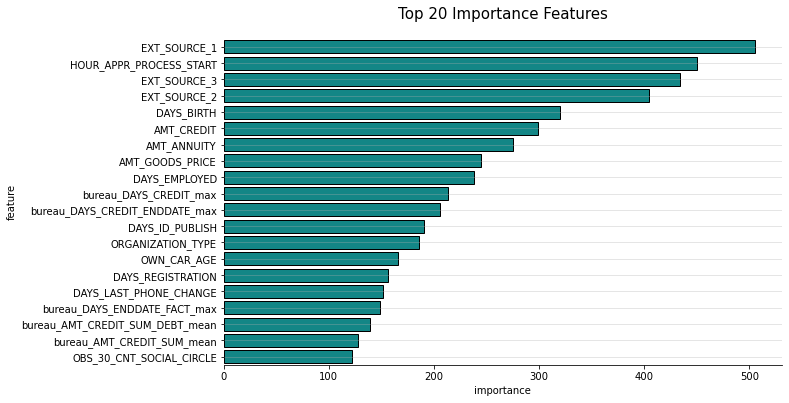

In [41]:
plot_top20_imp_feats(fi)